# Audio Processing

## Preliminaries

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
from copy import deepcopy
import scipy.io.wavfile
from scipy.signal import gaussian
from IPython.display import Audio
import matplotlib.pyplot as plt

## Scale a signal

In [2]:
def Fourier_scale(f, scale):
    N = len(f)
    F = fft(f)       # DFT of f
    F = fftshift(F)  # zero-shift so the DC is in the centre
    
    if scale>1.:
        padamt = int(N*(scale-1.)/2.)   # how much to pad each side (in time domain)
        G = np.pad(F, (padamt,padamt))  # pad both sides with 0s
        G = ifftshift(G)                # put DC back at index 0
        g = ifft(G)                     # IDFT
        g = g[:N]                       # take only 1st N elements
        
    elif scale<1.:
        cropamt = int(N*(1.-scale)/2.)  # how much to crop each side (in freq domain)
        G = F[cropamt:-cropamt]         # crop freq domain (symmetric about origin)
        G = ifftshift(G)                # put DC back at index 0
        g = ifft(G)                     # IDFT
        g = np.pad(g, (0,N-len(g)))     # add on the amount that was cropped
        
    else:
        g = f.copy()
    
    return g

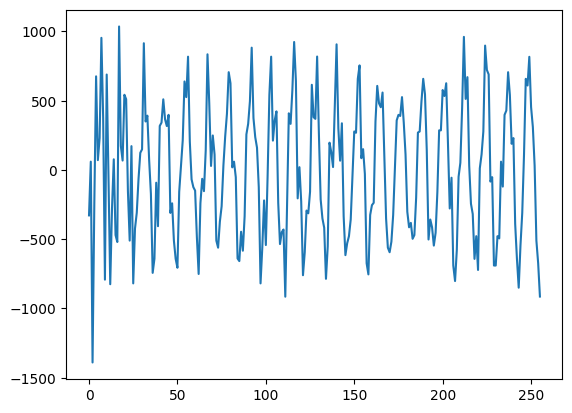

In [3]:
Omega, f = scipy.io.wavfile.read('train_bird.wav')
idx = int(0.51*Omega)
f = f[idx:idx+256]
plt.plot(f);

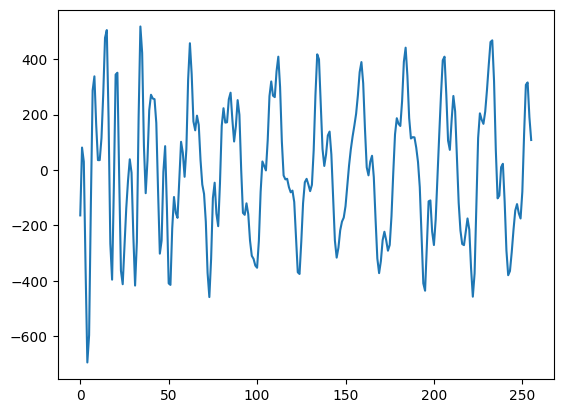

In [4]:
g = Fourier_scale(f, 2.)
plt.plot(np.real(g));

## Window functions

In [5]:
def tent_window(n):
    h = np.zeros((n,))
    n2 = int( np.ceil(n/2.) )
    ramp = np.linspace(0.,1,n2)
    h[:n2] = ramp
    if n%2 == 0:
        h[n2:] = ramp[::-1]
    else:
        h[n2:] = ramp[-2::-1]
    return h

In [6]:
def Hann_window(n):
    tt = np.arange(0, n)
    h = 0.5 * (1. - np.cos(2.*np.pi*tt/(n-1)))
    return h

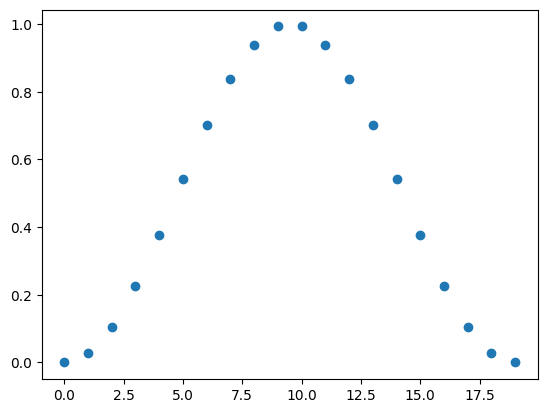

In [7]:
h = Hann_window(20)
plt.plot(h, 'o');

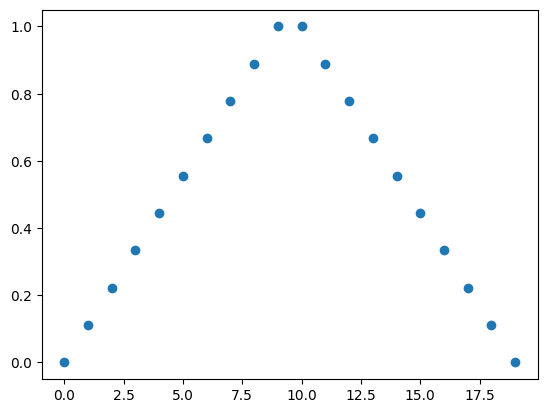

In [8]:
h = tent_window(20)
plt.plot(h, 'o');

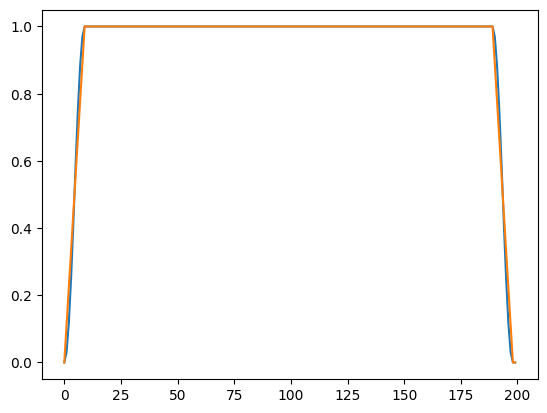

In [9]:
# This shows that both windows fully represent the internal
# part of the signal.
n = 19
N = 200
h = Hann_window(n)
g = tent_window(n)
nstep = int( np.floor(n/2.) )
hh = np.zeros((N,))
gg = np.zeros((N,))
for k in range(0,N-n,nstep):
    hh[k:k+n] += h
    gg[k:k+n] += g
plt.plot(hh);
plt.plot(gg);

## `MyAudio` class

In [10]:
class MyAudio():
    def __init__(self, fname=None, y=None, Omega=48000, dt=0.01):
        '''
         a = MyAudio(fname=None, y=None, Omega=48000, dt=0.01)
         
         Create a MyAudio object.
         
         Inputs:
          fname  name of wav file to read
                 If fname is given, arguments y and Omega are ignored.
          y      array of samples over time
          Omega  sample rate (Hz)
          dt     packet width (in seconds)
        '''
        if fname is not None:
            self.Omega, y = scipy.io.wavfile.read(fname)
            self.y = y.copy().astype(float)
            if len(self.y.shape) > 1:
                self.t = self.t[:,0]
        else:
            self.Omega = Omega
            self.y = y.astype(float)
        
        self.n_samples = len(self.y)
        self.duration = self.n_samples / self.Omega
        
        self.encode(dt)
    
    
    def encode(self, dt):
        '''
         a.encode(dt)
         Encodes the time-domain signal into a spectrogram, which is
         a time-frequency representation using the short-time Fourier transform.
        '''
        self.n_samplesinpacket = int(dt*self.Omega)  # packetwidth in samples
        self.h = Hann_window(self.n_samplesinpacket)
        self.packet_step = int( np.floor(self.n_samplesinpacket/2.) )
        self.n_packets = (self.n_samples-(self.n_samplesinpacket-self.packet_step)) // self.packet_step   # How many packets do we have
                
        # n2 is the number of Fourier coefs needed to reconstruct the real-valued input.
        self.n2 = int( np.floor(self.n_samplesinpacket//2 + 1) )
        
        #self.t_windows = np.arange(self.n_frames) / self.Omega
        
        self.Y = np.zeros((self.n_packets, self.n2), dtype=complex)
        for k in range(self.n_packets):
            idx = k * self.packet_step
            yw = self.y[idx:idx+self.n_samplesinpacket] * self.h # apply Hanning window
            Yw = fft(ifftshift(yw))
            self.Y[k,:] = Yw[:self.n2]
    
    
    def reconstruct(self):
        '''
         a.reconstruct()
         Generates the time-domain signal from the spectrogram.
        '''
        self.y[:] = 0
        for k in range(self.n_packets):
            idx = k * self.packet_step  # index for a packet
            
            # Reconstruct the whole DFT for the packet
            Ypos = self.Y[k,:]
            # Use conjugate symmetry to build the negative frequencies
            if self.n_samplesinpacket%2 == 0:
                Yneg = Ypos[-2:0:-1]
            else:
                Yneg = Ypos[-1:0:-1]
            yw = ifft( np.concatenate( (Ypos, np.conj(Yneg)) ) )
            # Copy samples into the time-domain signal
            self.y[idx:idx+self.n_samplesinpacket] += np.real(fftshift(yw))
            

    def play(self):
        '''
         a.play()
         Creates a widget to play the sound.
         Requires IPython.display.Audio. This might not work if being run on
         a server (eg. jupyterlab).
        '''
        return Audio(self.y, rate=self.Omega)
    
    def plot(self):
        '''
         a.plot()
         Plot the time-domain signal.
        '''
        t = np.linspace(0., self.duration, self.n_samples)
        plt.plot(t, self.y);
        plt.xlabel('Time (s)');
        
    def ti(self, t):
        '''
         idx = a.ti(t)
         Returns the sample index corresponding to time t (seconds).
        '''
        return int(t*self.Omega)
    
    def pi(self, t):
        '''
         idx = a.pi(t)
         Returns the packet index containing time t (seconds).
        '''
        return int(t*self.Omega/self.packet_step)
    
    def fi(self, f):
        '''
         idx = a.fi(t)
         Returns the frequency index containing frequency f (Hz).
        '''
        k = int(f*self.n_samplesinpacket/self.Omega)
        return k
    
    def shift_frequencies(self, tspan=None, fshift=0):
        '''
         a.shift_frequencies(tspan=None, fshift=0)
         Shift the frequencies in the time window up by fshift Hz.
         It shifts down if fshift is negative.
        '''
        if tspan is None:
            tspan = [0., self.duration]
        plo = self.pi(tspan[0])
        phi = self.pi(tspan[1])
        ishift = int( self.fi(abs(fshift)) * np.sign(fshift) )  # convert freq (Hz) to freq index
        for pidx in range(plo, phi+1):
            Ypacket = self.Y[pidx,:].copy()
            self.Y[pidx,:] = 0.
            if ishift>0:
                self.Y[pidx,ishift:] = Ypacket[:-ishift]
            elif ishift<0:
                self.Y[pidx,:ishift] = Ypacket[-ishift:]
        self.reconstruct()
    
    def mult_frequencies(self, tspan=None, mult=0.5):
        '''
         a.mult_frequencies(tspan=None, mult=0.5)
         Scale the frequency domain by mult over the given time interval.
         If tspan is None, it scales the whole signal.
        '''
        if tspan is None:
            tspan = [0., self.duration]
        plo = self.pi(tspan[0])
        phi = self.pi(tspan[1])
        for pidx in range(plo, phi+1):
            Y = self.Y[pidx,:]
            Ys = Fourier_scale(Y, mult)
            self.Y[pidx,:] = Ys
        self.reconstruct()
        
    def filter(self, tspan=None, band=None, mult=0.):
        '''
         a.filter(tspan=None, band=None, mult=0.)
         
         Multiply the Fourier coefs by a constant.
         It only applies the multiplier to Fourier coefs within
            time window    tspan[0] <= t < tspan[1], and
            frequency band  band[0] <= f < band[1]
            
         Inputs:
          tspan  array of start/end times (default all times)
          band   array of start/end frequencies (default all freqs)
          mult   multiplier for Fourier coefs (default 0)
        '''
        if tspan is None:
            plo = 0
            phi = self.n_samples
        else:
            plo = self.pi(tspan[0])
            phi = self.pi(tspan[1])
        
        if band is None:
            blo = 0
            bhi = int(self.n2)
        else:
            blo = self.fi(band[0])
            bhi = self.fi(band[1])
        if blo==bhi:
            self.Y[plo:phi, blo] = 0.
        else:
            self.Y[plo:phi, blo:bhi] = 0.
            
        self.reconstruct()
        
        
    
    def plot_spectrum(self, upto=None, logscale=True):
        '''
         a.plot_spectrum(upto=1000, logscale=True)
         
         Plot the time-frequency spectrum of the audio.
         
         Inputs:
          upto      plot only the bottom <upto> frequencies (Hz)
          logscale  plot coefs using logscale
        '''
        interp = 'bilinear'
        plt.figure(figsize=(10,8))
        if upto is None:
            upto = int( self.Omega/2. )
        if upto>self.Omega/2.:
            upto = int( self.Omega/2. )
        idx = int( upto / self.Omega * self.n_samplesinpacket )
        t_packet = np.arange(0, self.n_packets) * self.packet_step / self.Omega
        extent = [0, t_packet[-1], 0, upto]
        
        sig = self.Y[:,0:idx-1] #+ self.Y[:,1:idx]
        
        if logscale:
            plt.imshow(np.flipud(np.log(1.+np.abs(sig)).T), cmap='jet', extent=extent, interpolation=interp);
        else:
            plt.imshow(np.flipud(np.abs(sig).T), cmap='jet', extent=extent, interpolation=interp);
        
        plt.axis('auto');
        plt.xlabel('Time (s)'); plt.ylabel('Freq (Hz)');

## Load a signal

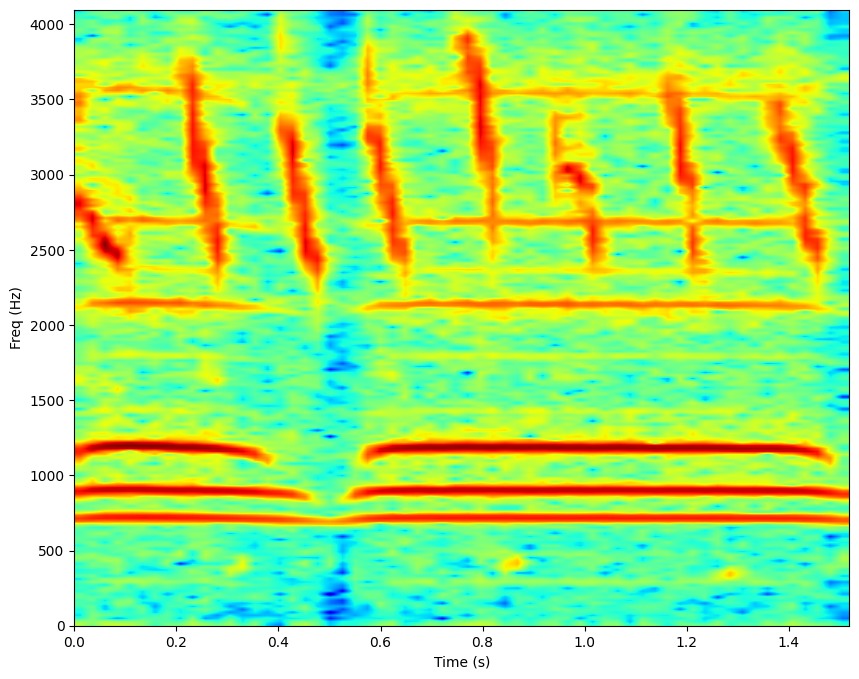

In [11]:
a = MyAudio('train_bird.wav', dt=0.05)
a.plot_spectrum(upto=5000)
a.play()

### Filtering works fine

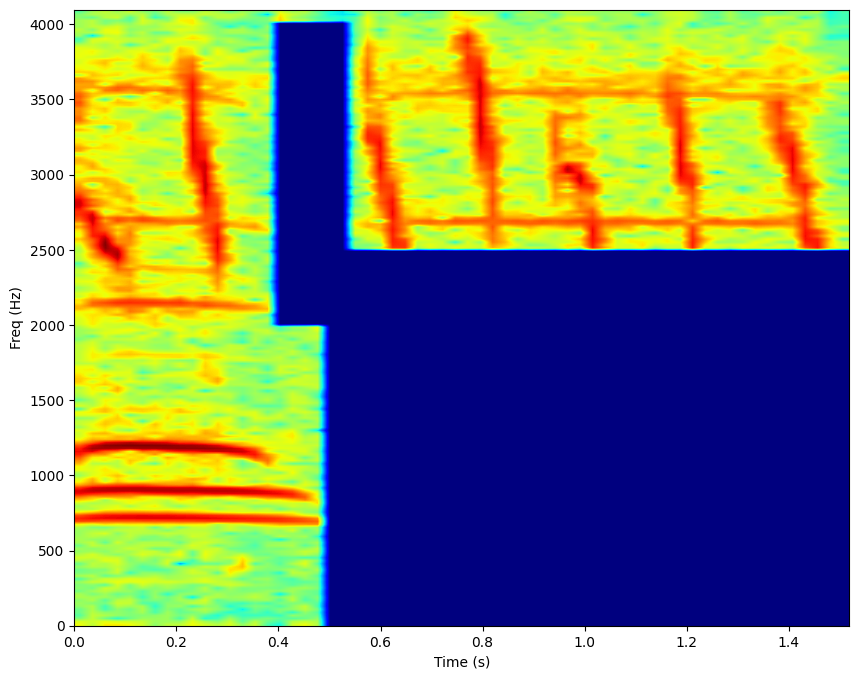

In [12]:
a.filter(tspan=[0.5,3.8], band=[0,2500])
a.filter(tspan=[0.4,0.55], band=[2000,4000])
a.plot_spectrum(upto=5000)
a.play()

### But frequency shifting or scaling does not

When I stretch a frequency band, it causes some sort of beat pattern.

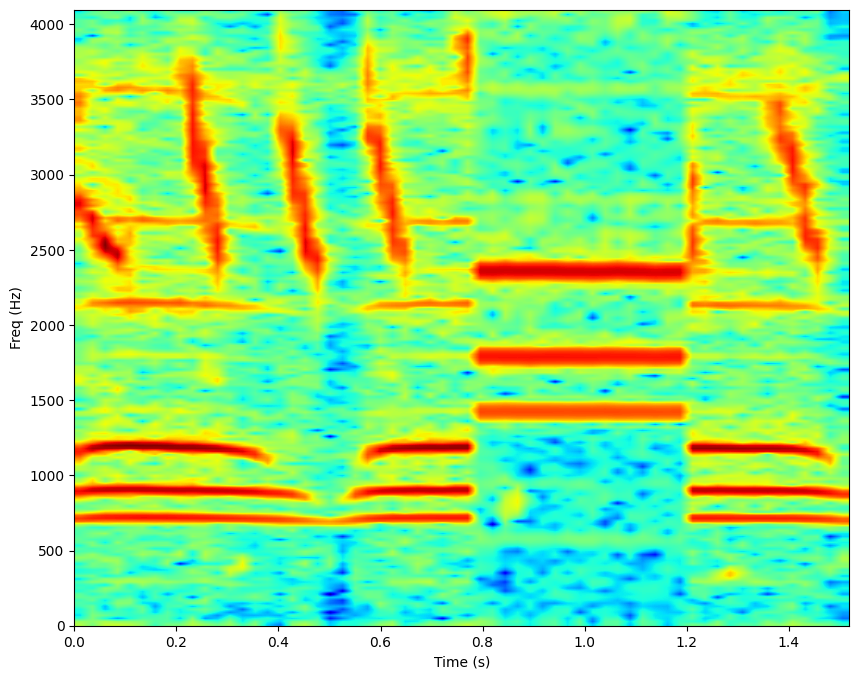

In [13]:
b = MyAudio('train_bird.wav', dt=0.05)
b.mult_frequencies(tspan=[0.8, 1.2], mult=2.)
b.plot_spectrum(upto=5000)
b.play()

Similarly for shifting frequencies.

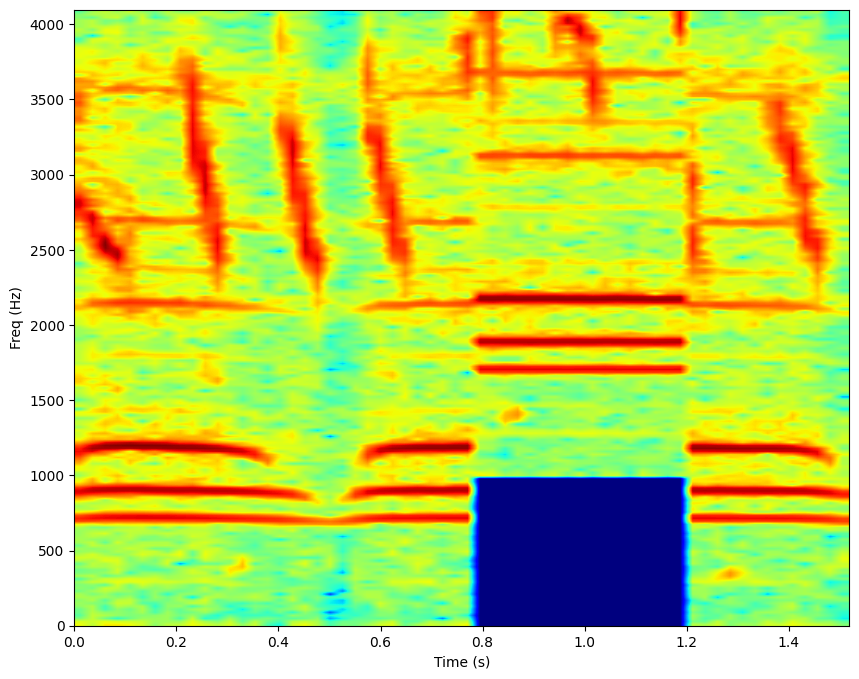

In [14]:
c = MyAudio('train_bird.wav', dt=0.05)
c.shift_frequencies(tspan=[0.8, 1.2], fshift=1000.)
c.plot_spectrum(upto=5000)
c.play()